In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/My Drive/ImageSegmentaion

/content/drive/My Drive/ImageSegmentaion


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

# Upload the Kaggle API key file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mostafanikosersht","key":"cc1b352732c49a8ef84f9e7d2451202b"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation --force


100% 2.29G/2.30G [00:45<00:00, 94.2MB/s]
100% 2.30G/2.30G [00:45<00:00, 53.7MB/s]


In [ ]:
!unzip -q uw-madison-gi-tract-image-segmentation.zip -d ./dataset

In [ ]:
!ls

dataset  kaggle.json  Untitled0.ipynb  uw-madison-gi-tract-image-segmentation.zip


In [ ]:
%cd dataset

/content/drive/My Drive/ImageSegmentaion/dataset


In [4]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.4 MB/s eta 0:00:00


In [5]:
!pip install -q portalocker>=2.0.0
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00


#****Import Libs****


In [6]:
!pip install segmentation_models_pytorch
import os
import sys
import time
import random
import tqdm
from glob import glob
from typing import Any, Callable, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torch import optim

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.datasets import VisionDataset
from torchvision.transforms import v2
from torchvision import tv_tensors

import segmentation_models_pytorch as smp

import torchmetrics as tm
from torchmetrics.aggregation import MeanMetric
from torchmetrics import Dice

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=642006d14a2b97abbeea3dc890a12193d23246e86e0ada33062f39f3b6ea957c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6cd6f93e9b4d4bb94181e681ff9b2606a062aa5fdfec97a86dcb22077fb1a413
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


#  **Utils**

In [7]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      # torch.cuda.manual_seed_all(seed)

      # torch.backends.cudnn.deterministic = True
      # torch.backends.cudnn.benchmark = False

#  **Arguments**

In [8]:
seed = 8
wandb_enable = False
root = 'data'
batch_size = 32
backbone = 'efficientnet-b1'
num_classes = 3
classes = ['large_bowel', 'small_bowel', 'stomach']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.1
momentum = 0.9
wd = 1e-4
num_epochs = 20
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

#  **Dataset**

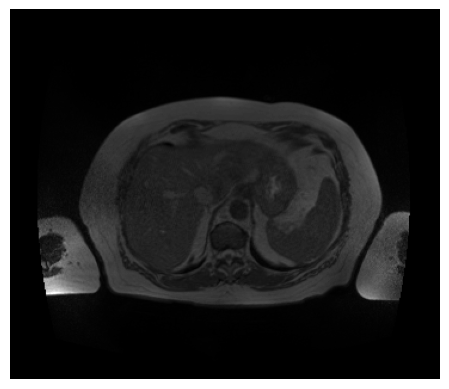

In [ ]:
img_path = r"data/train/case11/case11_day0/scans/slice_0039_360_310_1.50_1.50.png"
img = Image.open(img_path)
img_tensor = F.to_tensor(img)
normalizer = lambda x: (x - x.min()) / (x.max() - x.min())
img_norm = normalizer(img_tensor)
img_norm.dtype, img_norm.min(), img_norm.max()
plt.imshow(img_norm[0], cmap='gray')
plt.axis('off');

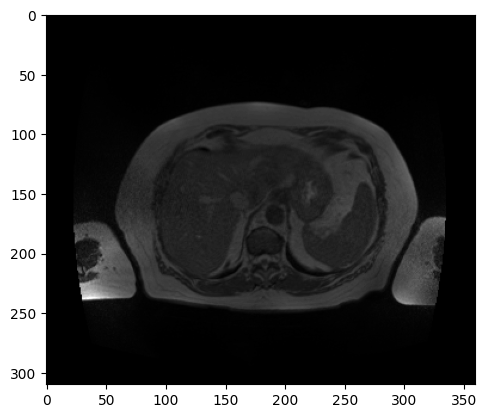

In [ ]:
img = Image.open(img_path)
img = F.to_tensor(img)
img = normalizer(img[0])
plt.imshow(img, cmap='gray');

In [ ]:
mask_name = 'case11_day0_slice_0039'
df = pd.read_csv(r'data/train.csv')
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
!ls

'=2.0.0'   ImageSegmentention.ipynb   uw-madison-gi-tract-image-segmentation.zip
 data	   kaggle.json


In [ ]:
sample = df[df['id'] == mask_name]
rle_mask = sample.iloc[2]['segmentation']
rle_mask

'47020 9 47378 12 47736 15 48095 16 48454 18 48813 20 49172 22 49532 23 49891 26 50251 27 50611 28 50970 30 51330 30 51690 30 52049 32 52409 32 52768 32 53113 8 53126 34 53470 50 53829 50 54189 50 54548 51 54908 50 55268 50 55628 49 55989 48 56350 47 56713 43 57078 37 57441 33 57803 31 58165 28 58527 26 58889 23 59250 21 59611 20 59972 18 60333 16 60695 13 61056 10 61418 7 61781 1'

In [ ]:
rle_list = rle_mask.split(' ')
starts, lengths = rle_list[::2], rle_list[1::2]
starts = np.array(starts, dtype=np.int32) - 1
lengths = np.array(lengths, dtype=np.int32)
ends = starts + lengths
starts, lengths, ends

(array([47019, 47377, 47735, 48094, 48453, 48812, 49171, 49531, 49890,
        50250, 50610, 50969, 51329, 51689, 52048, 52408, 52767, 53112,
        53125, 53469, 53828, 54188, 54547, 54907, 55267, 55627, 55988,
        56349, 56712, 57077, 57440, 57802, 58164, 58526, 58888, 59249,
        59610, 59971, 60332, 60694, 61055, 61417, 61780], dtype=int32),
 array([ 9, 12, 15, 16, 18, 20, 22, 23, 26, 27, 28, 30, 30, 30, 32, 32, 32,
         8, 34, 50, 50, 50, 51, 50, 50, 49, 48, 47, 43, 37, 33, 31, 28, 26,
        23, 21, 20, 18, 16, 13, 10,  7,  1], dtype=int32),
 array([47028, 47389, 47750, 48110, 48471, 48832, 49193, 49554, 49916,
        50277, 50638, 50999, 51359, 51719, 52080, 52440, 52799, 53120,
        53159, 53519, 53878, 54238, 54598, 54957, 55317, 55676, 56036,
        56396, 56755, 57114, 57473, 57833, 58192, 58552, 58911, 59270,
        59630, 59989, 60348, 60707, 61065, 61424, 61781], dtype=int32))

In [ ]:
mask = torch.zeros(img.numel(), dtype=torch.float32)

for start, end in zip(starts, ends):
  mask[start:end] = 1

mask.max()

tensor(1.)

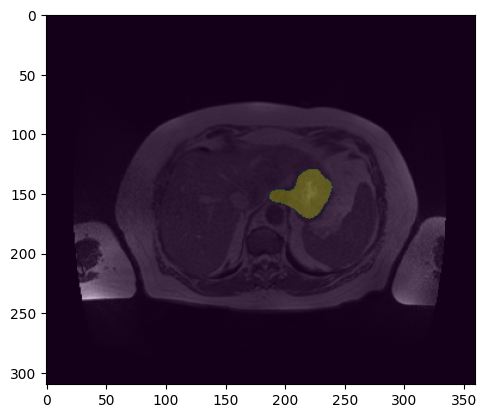

In [ ]:
mask2 = mask.reshape(img.shape)
mask2.shape
plt.imshow(img, cmap = 'gray');
plt.imshow(mask2, alpha = .3);

In [ ]:
x = torch.randint(0,10,(3,3))
x , x.flatten() , x.reshape(-1)

(tensor([[0, 8, 2],
         [8, 5, 0],
         [3, 4, 8]]),
 tensor([0, 8, 2, 8, 5, 0, 3, 4, 8]),
 tensor([0, 8, 2, 8, 5, 0, 3, 4, 8]))

In [ ]:
!ls

'=2.0.0'   ImageSegmentention.ipynb   uw-madison-gi-tract-image-segmentation.zip
 data	   kaggle.json


# **dataset preparation**


In [9]:
df = pd.read_csv(os.path.join(root,'train.csv'))
display(df.head())
df.shape

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


(115488, 3)

In [10]:
df.describe()

,id,class,segmentation
count,115488,115488,33913
unique,38496,3,33899
top,case123_day20_slice_0001,large_bowel,12629 10 12894 12 13158 15 13423 17 13688 19 1...
freq,3,38496,2


In [11]:
df.dropna(inplace=True)
display((df.head()))
df.shape

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


(33913, 3)

In [12]:
duplicates = df[df['segmentation'].duplicated(keep=False)]
duplicates

,id,class,segmentation
3259,case133_day25_slice_0079,small_bowel,29755 2 30112 8 30468 14 30826 17 31185 19 315...
3262,case133_day25_slice_0080,small_bowel,29755 2 30112 8 30468 14 30826 17 31185 19 315...
3638,case133_day23_slice_0061,stomach,34757 14 35114 19 35473 21 35831 23 36189 26 3...
3641,case133_day23_slice_0062,stomach,34757 14 35114 19 35473 21 35831 23 36189 26 3...
13134,case15_day20_slice_0059,large_bowel,28436 5 28701 7 28966 8 29232 9 29498 9 29765 ...
13137,case15_day20_slice_0060,large_bowel,28436 5 28701 7 28966 8 29232 9 29498 9 29765 ...
24745,case115_day0_slice_0105,small_bowel,16389 4 16648 15 16889 2 16913 24 17153 6 1717...
24748,case115_day0_slice_0106,small_bowel,16389 4 16648 15 16889 2 16913 24 17153 6 1717...
24751,case115_day0_slice_0107,small_bowel,16091 1 16114 4 16355 6 16379 8 16620 8 16644 ...
24754,case115_day0_slice_0108,small_bowel,16091 1 16114 4 16355 6 16379 8 16620 8 16644 ...


In [13]:
df.head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


In [14]:
df = df.pivot_table(index='id',columns='class',
                    values='segmentation',aggfunc='first')
df.reset_index(inplace=True)
display(df.head())
df.shape

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...


(16590, 4)

In [15]:
df.fillna('',inplace=True)

In [16]:
image_list = glob(os.path.join(root,'train','**','*.png'),recursive=True)
len(image_list)

38496

In [17]:
df.head()

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...


In [18]:
comps = image_list[0].split(os.path.sep)
'_'.join([comps[-3], comps[-1]]).rsplit('-',4)[0]

'case101_day20_slice_0001_266_266_1.50_1.50.png'

In [19]:
image_path_list = glob(os.path.join(root, 'train', '**', '*.png'), recursive=True)

id_list = []
for i in range(0, len(image_path_list)):
  components = image_path_list[i].split(os.path.sep)[-3::2]
  id_list.append('_'.join([components[0], components[1]]).rsplit('_', 4)[0])

df_path = pd.DataFrame()
df_path['id'] = id_list
df_path['path'] = image_path_list
display(df_path.head())
df_path.shape

,id,path
0,case101_day20_slice_0001,data/train/case101/case101_day20/scans/slice_0...
1,case101_day20_slice_0004,data/train/case101/case101_day20/scans/slice_0...
2,case101_day20_slice_0006,data/train/case101/case101_day20/scans/slice_0...
3,case101_day20_slice_0002,data/train/case101/case101_day20/scans/slice_0...
4,case101_day20_slice_0005,data/train/case101/case101_day20/scans/slice_0...


(38496, 2)

In [20]:
df.head()

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...


In [21]:
df = df.merge(df_path, on='id')
df.head()

,id,large_bowel,small_bowel,stomach,path
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,data/train/case101/case101_day20/scans/slice_0...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,data/train/case101/case101_day20/scans/slice_0...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,data/train/case101/case101_day20/scans/slice_0...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,data/train/case101/case101_day20/scans/slice_0...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,data/train/case101/case101_day20/scans/slice_0...


In [22]:
df['case'] = df['id'].apply(lambda x: x.split('_')[0].replace('case', ''))

df['day'] = df['id'].apply(lambda x: int(x.split('_')[1].replace('day', '')))

df['slice'] = df['id'].apply(lambda x: x.split('_')[3])

df['width'] = df['path'].apply(lambda x: int(x[:-4].rsplit("_", 4)[1]))

df['height'] = df['path'].apply(lambda x: int(x[:-4].rsplit("_", 4)[2]))

df['counts'] = np.sum(df.iloc[:, 1:4] != '', axis=1).values

display(df.head())
df['counts'].unique()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,data/train/case101/case101_day20/scans/slice_0...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,data/train/case101/case101_day20/scans/slice_0...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,data/train/case101/case101_day20/scans/slice_0...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,data/train/case101/case101_day20/scans/slice_0...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,data/train/case101/case101_day20/scans/slice_0...,101,20,0070,266,266,1


array([1, 2, 3])

In [23]:
train_cases = open(os.path.join(root, 'train.txt')).read().replace('case','').split('\n')

In [24]:
df_train = df[df['case'].isin(train_cases)]
df_train.shape

(12030, 11)

In [25]:
df_train.to_csv(os.path.join(root,'train-subset.csv'),index=False)

In [26]:
valid_cases = open(os.path.join(root, 'validation.txt')).read().replace('case', '').split('\n')
# valid_cases
df_valid = df[df['case'].isin(valid_cases)]
display(df_valid.head())
df_valid.shape
df_valid.to_csv(os.path.join(root, 'valid-subset.csv'), index=False)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
2763,case122_day0_slice_0051,,,35851 9 36211 12 36571 14 36931 14 37291 15 37...,data/train/case122/case122_day0/scans/slice_00...,122,0,0051,360,310,1
2764,case122_day0_slice_0052,,,34414 2 34417 3 34772 8 35131 10 35490 12 3584...,data/train/case122/case122_day0/scans/slice_00...,122,0,0052,360,310,1
2765,case122_day0_slice_0053,,,34419 1 34778 4 35131 12 35489 16 35848 18 362...,data/train/case122/case122_day0/scans/slice_00...,122,0,0053,360,310,1
2766,case122_day0_slice_0054,,,33339 2 33697 6 34057 8 34416 10 34773 14 3512...,data/train/case122/case122_day0/scans/slice_00...,122,0,0054,360,310,1
2767,case122_day0_slice_0055,,,32257 4 32615 8 32974 11 33333 14 33692 16 340...,data/train/case122/case122_day0/scans/slice_00...,122,0,0055,360,310,1


In [27]:
test_cases = open(os.path.join(root, 'test.txt')).read().replace('case', '').split('\n')
# test_cases
df_test = df[df['case'].isin(test_cases)]
display(df_test.head())
df_test.shape
df_test.to_csv(os.path.join(root, 'test-subset.csv'), index=False)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
674,case110_day12_slice_0048,,,35874 3 36232 11 36591 14 36950 17 37310 18 37...,data/train/case110/case110_day12/scans/slice_0...,110,12,0048,360,310,1
675,case110_day12_slice_0049,,,34429 12 34788 15 35147 17 35506 19 35865 22 3...,data/train/case110/case110_day12/scans/slice_0...,110,12,0049,360,310,1
676,case110_day12_slice_0050,,,33709 6 34066 12 34424 18 34783 22 35141 26 35...,data/train/case110/case110_day12/scans/slice_0...,110,12,0050,360,310,1
677,case110_day12_slice_0051,,,33347 8 33705 14 34063 19 34421 24 34779 28 35...,data/train/case110/case110_day12/scans/slice_0...,110,12,0051,360,310,1
678,case110_day12_slice_0052,,,32988 6 33344 15 33702 20 34061 23 34419 26 34...,data/train/case110/case110_day12/scans/slice_0...,110,12,0052,360,310,1


In [28]:
df_test.shape

(3067, 11)

#**EDA**

In [9]:
df_train = pd.read_csv(r'data/train-subset.csv')
df_train.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...,data/train/case101/case101_day20/scans/slice_0...,101,20,66,266,266,1
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...,data/train/case101/case101_day20/scans/slice_0...,101,20,67,266,266,1
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,data/train/case101/case101_day20/scans/slice_0...,101,20,68,266,266,1
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...,data/train/case101/case101_day20/scans/slice_0...,101,20,69,266,266,1
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...,data/train/case101/case101_day20/scans/slice_0...,101,20,70,266,266,1


In [10]:
def rle_decode(img_size, segments):
  mask = torch.zeros(3, img_size[0] * img_size[1], dtype=torch.float32)
  for i, segment in enumerate(segments):
    if str(segment) != 'nan':
      segment = segment.split()
      starts = np.array(segment[::2], dtype=np.int32) - 1
      ends = starts + np.array(segment[1::2], dtype=np.int32)
      for s, e in zip(starts, ends):
        mask[i, s:e] = 1
  return mask.reshape((3, img_size[0], img_size[1]))

In [11]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Lambda(lambda x:
                                                        (x - x.min()) /
                                                        (x.max() - x.min())),
                                      transforms.Lambda(lambda x:
                                                        x.repeat(3, 1, 1))])

target_transform = transforms.Compose([transforms.Resize((224, 224))])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


red: large_bowel, green: small_bowel, blue: stomach


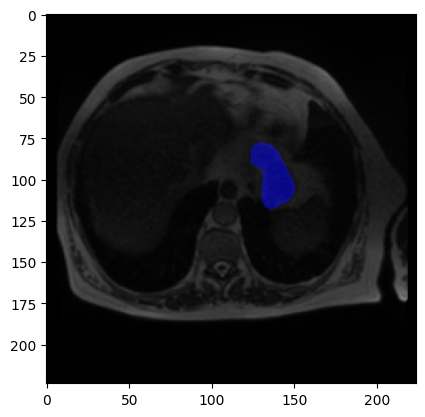

In [12]:
item = random.randint(0, df_train.shape[0])
sample = df_train.iloc[item]

img = Image.open(sample['path'])

mask = rle_decode(img.size[::-1],
                  sample[['large_bowel', 'small_bowel', 'stomach']])

img = train_transform(img)
mask = target_transform(mask)

plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.imshow(mask.permute(1, 2, 0), alpha=0.5)
print('red: large_bowel, green: small_bowel, blue: stomach');

In [13]:
img_temp = cv2.imread(sample['path'],cv2.IMREAD_UNCHANGED)
img_temp.shape , img_temp.dtype

((266, 266), dtype('uint16'))

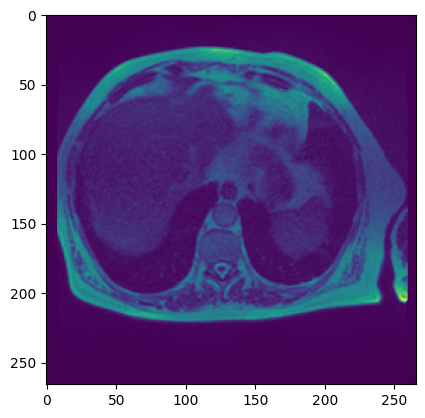

In [14]:
plt.imshow(img_temp)

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12030 entries, 0 to 12029
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12030 non-null  object
 1   large_bowel  10143 non-null  object
 2   small_bowel  8190 non-null   object
 3   stomach      6191 non-null   object
 4   path         12030 non-null  object
 5   case         12030 non-null  int64 
 6   day          12030 non-null  int64 
 7   slice        12030 non-null  int64 
 8   width        12030 non-null  int64 
 9   height       12030 non-null  int64 
 10  counts       12030 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 1.0+ MB


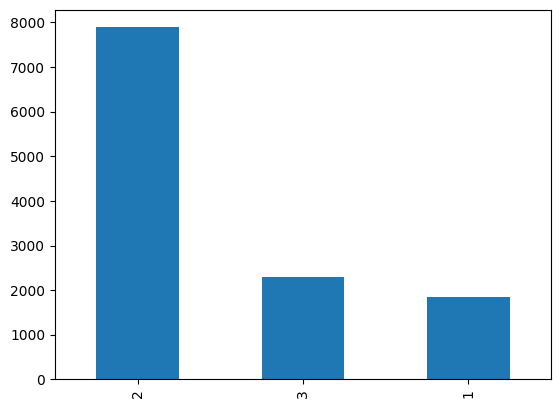

In [15]:
df_train['counts'].value_counts().plot(kind='bar');

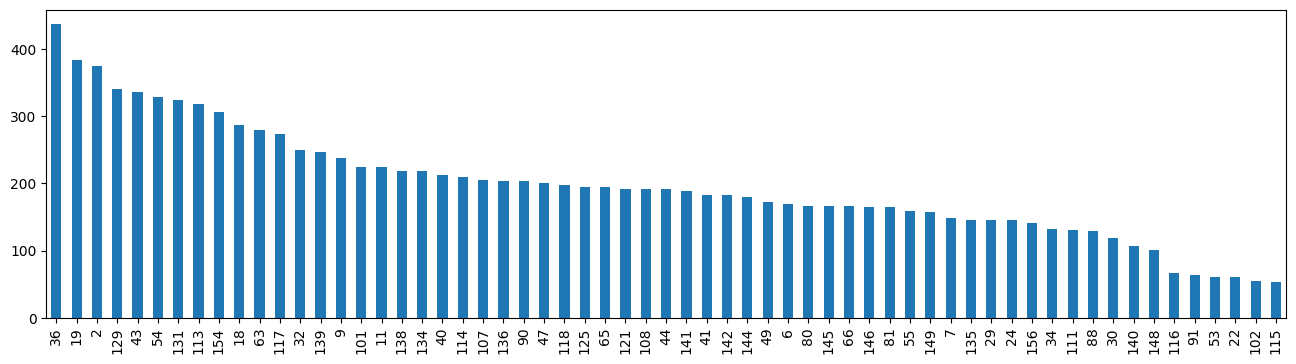

In [42]:
plt.figure(figsize=(16,4))
df_train['case'].value_counts().plot(kind='bar');

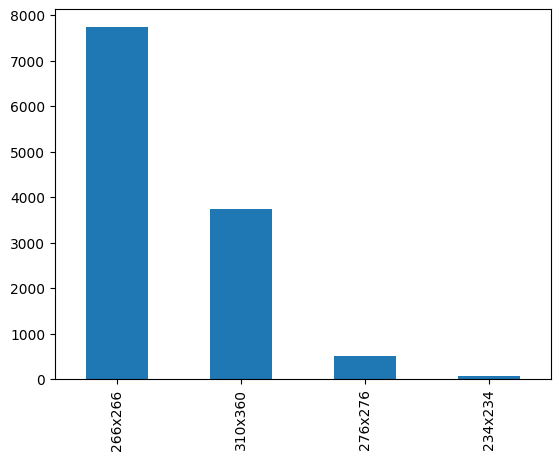

In [43]:
img_sizes = df_train['height'].apply(lambda x: str(x))
 + 'x' + df_train['width'].apply(lambda x: str(x))
img_sizes.value_counts().plot(kind='bar');

In [45]:
total_nbytes = 0

for path in df_train['path']:
  img = cv2.imread(path)
  total_nbytes += img.nbytes

print(total_nbytes/1e6)

3016.077948


# **Custom Dataset**

In [16]:
class UWMadisonDataset(VisionDataset):

    def __init__(self, root: str, csv_file: str,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None):

        super().__init__(root, transform=transform, target_transform=target_transform)

        self.df = pd.read_csv(os.path.join(root, csv_file))

        self.classes = ['large_bowel', 'small_bowel', 'stomach']

    def __getitem__(self, item):
        sample = self.df.iloc[item]

        img = Image.open(sample['path'])
        mask = rle_decode(img.size[::-1], sample[self.classes])

        img = self.transform(img)
        mask = self.target_transform(mask)

        return img, mask

    def __len__(self):
        return self.df.shape[0]

In [17]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      # transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor(),
                                      transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
                                      transforms.Lambda(lambda x: x.repeat(3, 1, 1))])

target_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      #  transforms.RandomHorizontalFlip(0.5)
                                      ])

train_set = UWMadisonDataset(root, 'train-subset.csv',
                              transform=train_transform,
                              target_transform=target_transform)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


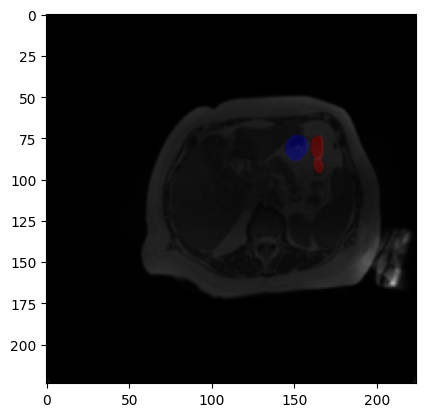

In [18]:
item = random.randint(0, len(train_set))

img, mask = train_set[item]

plt.imshow(img[0], cmap='gray')
plt.imshow(mask.permute(1, 2, 0), alpha=0.3);

#**data loader V2**

In [19]:
from torchvision.transforms import v2
class UWMadisonDataset(VisionDataset):

    def __init__(self, root: str, csv_file: str,
                 transforms: Optional[Callable] = None):

        super().__init__(root, transforms=transforms)

        self.df = pd.read_csv(os.path.join(root, csv_file))

        self.classes = ['large_bowel', 'small_bowel', 'stomach']

    def __getitem__(self, item):
        sample = self.df.iloc[item]

        img = Image.open(sample['path'])
        mask = rle_decode(img.size[::-1], sample[self.classes])

        img = tv_tensors.Image(img)
        mask = tv_tensors.Mask(mask)

        img, mask = self.transforms(img, mask)

        return img, mask

    def __len__(self):
        return self.df.shape[0]

In [20]:
transform_train = v2.Compose([
    v2.Resize(size=(234,), antialias=True),
    v2.RandomCrop(size=(224, 224)),
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

train_set = UWMadisonDataset(root, 'train-subset.csv',
                             transforms=transform_train)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) [-1.0, 1.0] tensor([0., 1.])


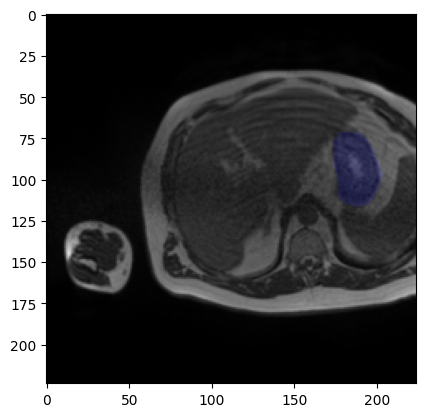

In [21]:
item = random.randint(0, len(train_set))
img, mask = train_set[item]
print(img.shape, mask.shape, [img.min().item(), img.max().item()], mask.unique())

plt.imshow(img[0], cmap='gray')
plt.imshow(mask.permute(1, 2, 0), alpha=0.15);

# **RAM**

In [22]:
class UWMadisonDataset(VisionDataset):

  def __init__(self, root: str, csv_file: str,
               transforms: Optional[Callable] = None,
               memory: Optional[bool] = False):

    super().__init__(root, transforms=transforms)

    self.df = pd.read_csv(os.path.join(root, csv_file))

    self.classes = ['large_bowel', 'small_bowel', 'stomach']

    self.memory = memory
    if memory:
      self._save_memory()

  def __getitem__(self, item):
    sample = self.df.iloc[item]

    img = self.imgs[item] if self.memory else self._load_image(sample['path'])
    # print(img.shape)

    mask = rle_decode(img.shape[1::], sample[self.classes])
    mask = tv_tensors.Mask(mask)

    img, mask = self.transforms(img, mask)
    return img, mask.int()

  def __len__(self):
    return self.df.shape[0]

  def _save_memory(self):
    self.imgs = []
    for path in self.df['path']:
      self.imgs.append(self._load_image(path))

  def _load_image(self, path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = self._minmax_scaler(img)
    return tv_tensors.Image(img)

  def _minmax_scaler(self, x):
    return np.array((x - x.min()) / (x.max() - x.min()), dtype=np.float32)

In [23]:
transform_train = v2.Compose([
    v2.Resize(size=(234,), antialias=True),
    v2.RandomCrop(size=(224, 224)),
    v2.RandomPhotometricDistort(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

transform_eval = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
    v2.Normalize(mean=(0.5,), std=(0.5,)),
    v2.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

In [24]:
train_set = UWMadisonDataset(root, 'train-subset.csv', transforms=transform_train, memory=True)

valid_set = UWMadisonDataset(root, 'valid-subset.csv', transforms=transform_eval, memory=True)

test_set = UWMadisonDataset(root, 'test-subset.csv', transforms=transform_eval)

len(train_set), len(valid_set), len(test_set)

KeyboardInterrupt: 

In [ ]:
tem = random.randint(0, len(train_set))
img, mask = train_set[item]
print(img.shape, mask.shape, [img.min().item(), img.max().item()], mask.unique())

plt.imshow(img[0], cmap='gray')
plt.imshow(mask.permute(1, 2, 0), alpha=0.3);

# **DataLoader**

In [ ]:
train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set,batch_size=batch_size, shuffle=True)

In [ ]:
imgs, msks = next(iter(train_loader))
imgs.shape , msks.shape

In [ ]:
def time_for_each_batch(loader):
  start = time.time()
  for iter, (img, mask) in enumerate(loader, 1):
    continue
  end = time.time()
  total_time = end - start
  return total_time, total_time/len(loader)

In [ ]:
print(time_for_each_batch(train_loader))
print(time_for_each_batch(valid_loader))
print(time_for_each_batch(test_loader))

#**Model**

In [ ]:
#first model

model = smp.Unet(encoder_name=backbone , encoder_weights='imagenet',
                in_channels=3,classes=3)

In [ ]:
imgs, mask = next(iter(train_loader))
model(imgs).shape

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

model = model.to(device)

start.record()
with torch.no_grad():
  out = model(imgs.to(device))
end.record()

torch.cuda.synchronize()

start.elapsed_time(end)

# **Config**

In [ ]:
loss_fn = smp.losses.DiceLoss(mode='multilabel')
metric  = Dice().to(device)

In [ ]:
if wandb_enable:
  key_file = '/content/key'

  if os.path.exists(key_file):
    with open(keyfile)as f:
      key = f.readline().strip()
    wandb.login(key.key)
  else:
    print('key not excis')

#  **Train **

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = MeanMetric()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), weight=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.compute().item(),
                         metric=metric.compute().item())

  return model, loss_train.compute().item(), metric.compute().item()

#**eval **

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = MeanMetric()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), weight=len(targets))

      metric(outputs, targets)

  return loss_eval.compute().item(), metric.compute().item()

In [ ]:
model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet', classes=num_classes).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

In [ ]:
mini_valid_size = 500
_, mini_valid_dataset = random_split(valid_set, (len(valid_set)-mini_valid_size, mini_valid_size))
mini_valid_loader = DataLoader(mini_valid_dataset, 20, shuffle=True)
model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet',
                 in_channels=3, classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_fn = smp.losses.DiceLoss(mode='multilabel')

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_valid_loader, loss_fn, optimizer, metric, epoch+1)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 3

for lr in [0.9, 0.5, 0.3, 0.1, 0.01, 0.001]:
  print(f'LR={lr}')

  model = smp.Unet(encoder_name=backbone, encoder_weights='imagenet', classes=num_classes, in_channels=3).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, valid_loader, loss_fn, optimizer, metric, epoch+1)

  print()

In [ ]:
torch.cuda.empty_cache()

In [1]:
 set_seed(seed)
 model = model = smp.Unet(encoder_name=backbone,encoder_weights='imagent',
                          in_channels=3,classes=num_classes).to(device)

NameError: name 'set_seed' is not defined

In [ ]:
set_seed(seed)
lr = 0.3
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=[5, 10, 15], gamma=0.1)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch+1)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}, LR = {lr_scheduler.get_last_lr()[0]}')
  print()

  lr_scheduler.step()

  epoch_counter += 1

In [ ]:
#plot
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
test_loader = DataLoader(test_set, batch_size=32)

In [ ]:
_, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()
def segment(image, model):
  with torch.inference_mode():
    prediction = model(image)
    return torch.sigmoid(prediction).cpu()


In [ ]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
img, mask = next(iter(test_loader))

output = segment(img.to(device), model)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img[0, 0], cmap='gray');
plt.title('Input')

plt.subplot(1, 3, 2)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(output[0].permute(1, 2, 0), alpha=0.3);
plt.title('Model')

plt.subplot(1, 3, 3)
plt.imshow(img[0, 0], cmap='gray');
plt.imshow(mask[0].permute(1, 2, 0).float(), alpha=0.3);
plt.title('Target');